In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.11.0


In [3]:
train_dir = Path('../content/drive/MyDrive/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [4]:
test_dir = Path('../content/drive/MyDrive/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [5]:
val_dir = Path('../content/drive/MyDrive/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [6]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

   
    df = pd.concat([filepath, labels], axis=1)

   
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [7]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [8]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['kiwi' 'cauliflower' 'beetroot' 'bell pepper' 'watermelon' 'pomegranate'
 'sweetcorn' 'turnip' 'carrot' 'corn' 'onion' 'lemon' 'sweetpotato'
 'soy beans' 'mango' 'banana' 'lettuce' 'spinach' 'cabbage' 'peas'
 'raddish' 'potato' 'pineapple' 'paprika' 'grapes' 'pear' 'tomato'
 'garlic' 'capsicum' 'orange' 'eggplant' 'cucumber' 'chilli pepper'
 'ginger' 'jalepeno' 'apple']


In [9]:
train_df.head(5)

,Filepath,Label
0,../content/drive/MyDrive/train/kiwi/Image_35.jpg,kiwi
1,../content/drive/MyDrive/train/cauliflower/Ima...,cauliflower
2,../content/drive/MyDrive/train/beetroot/Image_...,beetroot
3,../content/drive/MyDrive/train/bell pepper/Ima...,bell pepper
4,../content/drive/MyDrive/train/beetroot/Image_...,beetroot


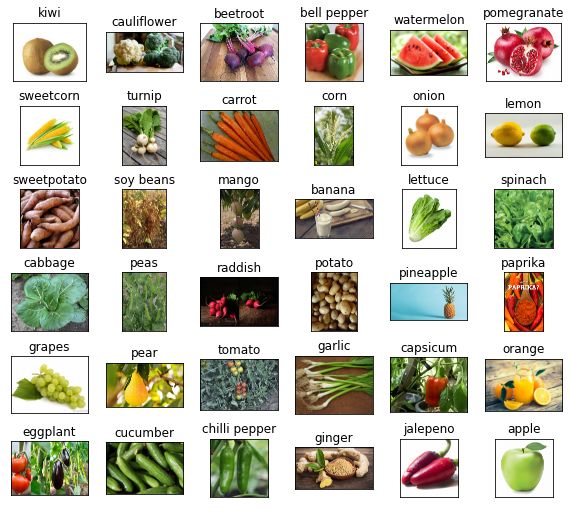

In [10]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2780 validated image filenames belonging to 36 classes.


In [13]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 334 validated image filenames belonging to 36 classes.


In [14]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 334 validated image filenames belonging to 36 classes.


In [15]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [20]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/2
87/87 [==============================] - 148s 2s/step - loss: 1.7505 - accuracy: 0.5245 - val_loss: 0.4608 - val_accuracy: 0.8802
Epoch 2/2
87/87 [==============================] - 133s 2s/step - loss: 0.5473 - accuracy: 0.8306 - val_loss: 0.3009 - val_accuracy: 0.9132


In [17]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 18s 2s/step


['sweetpotato',
 'cabbage',
 'raddish',
 'onion',
 'garlic',
 'paprika',
 'peas',
 'pear',
 'pomegranate',
 'watermelon',
 'garlic',
 'cauliflower',
 'sweetcorn',
 'pomegranate',
 'watermelon',
 'banana',
 'watermelon',
 'pear',
 'potato',
 'banana',
 'paprika',
 'soy beans',
 'soy beans',
 'apple',
 'potato',
 'mango',
 'chilli pepper',
 'peas',
 'eggplant',
 'spinach',
 'beetroot',
 'carrot',
 'sweetpotato',
 'peas',
 'sweetcorn',
 'pineapple',
 'jalepeno',
 'soy beans',
 'cauliflower',
 'pineapple',
 'kiwi',
 'garlic',
 'turnip',
 'eggplant',
 'pineapple',
 'eggplant',
 'cabbage',
 'watermelon',
 'peas',
 'pear',
 'garlic',
 'capsicum',
 'lemon',
 'tomato',
 'cauliflower',
 'jalepeno',
 'orange',
 'cucumber',
 'kiwi',
 'tomato',
 'pineapple',
 'cabbage',
 'lettuce',
 'pear',
 'beetroot',
 'jalepeno',
 'banana',
 'sweetpotato',
 'kiwi',
 'peas',
 'orange',
 'spinach',
 'sweetpotato',
 'pear',
 'peas',
 'paprika',
 'mango',
 'bell pepper',
 'raddish',
 'kiwi',
 'lettuce',
 'turnip',
 

In [18]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [23]:
img = output('/content/drive/MyDrive/test/spinach/Image_4.jpg')
img

1/1 [==============================] - 0s 44ms/step


'spinach'